In [6]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io as sio
import os
import json

from scipy.stats import linregress

from multiprocessing import Pool

from tqdm import tqdm

from time import time

from functions import tuplinator, init_Frame, SSub_ntau, twodim_graphs, name_toidx, mat_toevoked, reduceCS

**Backward Masking Experiment Dictionary**

In [2]:
#Conditions codes
conditions_dict = {'con_left_self': 'S__1',
                   'con_left_other': 'S__2',
                   'con_right_self': 'S__3',
                   'con_right_other': 'S__4',
                   'uncon_left_self': 'S_11',
                   'uncon_left_other': 'S_12',
                   'uncon_right_self': 'S_13',
                   'uncon_right_other': 'S_14',}

sub_list = ['001','002','003','004','005','006','007','008','009','010',
            '011','012','013','014','015','016','017','018','019','020',
            '023','024','025','026','028','029','030',
            '031','033','034','035','036','037','038','040',
            '042']

**Get elecrodes indexing and select points of interest**

In [ ]:
#Data paths

#Workflow folder path
wf_path = '/home/lunis/Documents/nlin-EEG/'

#Backward Masking dataset path
bw_path = wf_path + 'data/backward_masking/'

#Load channel names
ch_path = bw_path + 'subj001_band_resample/channel.mat'

# Parieto-Occipital and Frontal
ch_clust = ['O2','PO4','PO8'],['Fp1','Fp2','Fpz']

#Make a tuple out of a list
#ch_clust = tuplinator(ch_clust)

# Load the .mat file (adjust the path)
mat_data = sio.loadmat(ch_path)

ch_list = []
for m in mat_data['Channel'][0]:
#     print(m[0][0])
    ch_list.append(str(m[0][0]))


ch_list_idx = name_toidx(ch_list)
ch_clust_idx = name_toidx(ch_clust)

**Transform data in evoked format for easier data fetching**

In [ ]:
# Get conditions, averaged across conscious and unconscious, and for every subcondition
conditions = ['S__','S_1',
              'S__1', 'S__2', 'S__3', 'S__4', 'S_11', 'S_12', 'S_13', 'S_14']

# Sampling frequency of the experiment
freq = 500

# Prepare directory for results
os.makedirs(wf_path + 'BM_evoked/', exist_ok = True)

#Create iterable function
def evoks(subID):

    evoks = mat_toevoked(subID, conditions = conditions, exp = 'bw', freq = freq)

    return evoks

# Set multiprocessing parameters
workers = os.cpu_count()-2

# Run calculations
if __name__ == '__main__':
    with Pool(workers) as p:
        datas = tqdm(p.map(evoks, sub_list), 
                    desc= 'Evoking:',
                    leave = False)

        for i, data in enumerate(datas):

            mne.write_evokeds(wf_path + 'evoked/' + sub_list[i] + '-ave.fif', data, overwrite = True, verbose = False)


**Check $C(m,r)$ very average behaviour**

For new results, edit the script and run *'python -m correlation'* in the console.

In [ ]:
# Legend

#Axis 0 = Subjects
#Axis 1 = Conditions
#Axis 2 = Electrodes
#Axis 3 = m: Embedding dimension
#Axis 4 = r

# Load results from correlation.py script
CS = np.load(wf_path + 'BM_CS/CSumswholesignal.npy')
r = np.load(wf_path + 'BM_CS/rvalswholesignal.npy')

embs = [i for i in range(2,CS.shape[3]+2)]

# Get average across subjects across channels (for now)
CS = CS.mean(axis = 0)

CScon = CS[0,:,:,:]
CSunc = CS[1,:,:,:]

CScon_std = CScon.std(axis = 0)
CSunc_std = CSunc.std(axis = 0)

CScon = CScon.mean(axis = 0)
CSunc = CSunc.mean(axis = 0)

fig, axs = plt.subplots(1,2, figsize = (15,10), dpi = 300)

for i, c in enumerate(CScon):
    axs[0].errorbar(r, c, yerr = CScon_std[i,:], capsize = 3, elinewidth = 1, barsabove = True,
                          marker = 'o', markersize = 2, linewidth = 0.5, label = 'm = ' + str(embs[i]))

axs[0].set_title('Conscious presentation')

for i, c in enumerate(CSunc):
    axs[1].errorbar(r, c, yerr = CSunc_std[i,:], capsize = 3, elinewidth = 1, barsabove = True,
                          marker = 'o', markersize = 2, linewidth = 0.5)#, label = 'm = ' + str(embs[i]))

axs[1].set_title('Masked presentation')

for ax in axs:
    ax.grid()

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel('$r$')
    ax.set_ylabel('$C(m,r)$')

fig.legend(loc = 'center right')
plt.savefig(wf_path + 'pics/backward_masking/averageCsum.png', dpi = 300)
plt.show()

**Results of the Grassberger-Procaccia algorithm for $D^{2}$**

For new results, edit the script and run *'python -m logfit'* in the console.

In [ ]:
# Legend

#Axis 0 = Subjects
#Axis 1 = Conditions
#Axis 2 = Electrodes
#Axis 3 = m: Embedding dimension
#Axis 4 = r

# Load results from correlation.py script
CS = np.load(wf_path + 'BM_CS/CSumswholesignal.npy')
r = np.load(wf_path + 'BM_CS/rvalswholesignal.npy')

embs = [i for i in range(2,CS.shape[3]+2)]

# Fit parameters
vmin = 5
vmax = 28

# Load results from logfit.py script
m = np.load(wf_path + 'BM_CS/D2/' + str(vmin) + '_' + str(vmax) + 'slopes.npy')
em = np.load(wf_path + 'BM_CS/D2/' + str(vmin) + '_' + str(vmax) + 'errslopes.npy')
q = np.load(wf_path + 'BM_CS/D2/' + str(vmin) + '_' + str(vmax) + 'intercept.npy')
eq = np.load(wf_path + 'BM_CS/D2/' + str(vmin) + '_' + str(vmax) + 'errintercept.npy')
z = np.load(wf_path + 'BM_CS/D2/' + str(vmin) + '_' + str(vmax) + 'zscore.npy')

In [ ]:
# Check expected attractor dimension 

M = m.mean(axis = 2)
#EM = em.mean(axis = 2)
#Q = q.mean(axis = 2)
#EQ = eq.mean(axis = 2)

title = '$D_{2}(m)$'

fig, axs = plt.subplots(6,6, figsize = (12,10))

for j, ax in enumerate(axs.flat):
    
    ax.plot(embs, M[j,0,:], label = 'Conscious')
    ax.plot(embs, M[j,1,:], label = 'Unconscious')

    #ax.set_title(sub_list[j])

fig.suptitle(title, size = 25)

plt.savefig(wf_path + 'pics/backward_masking/Dattractor.png', dpi = 300)

fig.show()

In [ ]:
# Check Z-score distributions for each subject
for i, d in enumerate(embs):

    title = '$\\mathcal{Z}$-scores for $m=$' + str(d)

    fig, axs = plt.subplots(6,6, figsize = (15,13))

    for j, ax in enumerate(axs.flat):
        
        ax.hist(z[j,0,:,i], bins = 10, alpha = 0.5, label = 'Conscious Z')
        ax.hist(z[j,1,:,i], bins = 10, alpha = 0.5, label = 'Unconscious Z')

        #ax.set_title(sub_list[j])

    fig.suptitle(title, size = 30)

    plt.savefig(wf_path + 'pics/backward_masking/' + str(d) + 'Zscores.png', dpi = 300)

    fig.show()

**Check just for Parieto-Occipital and Frontal electrodes**

*Reduce $C(m,r)$ over electrodes in clusters and set result logfit.py script to average over electrodes*

In [4]:
# Create new directory with appropriate labeling

# Parieto-Occipital electrodes
lb = 'PO'
pois = ['O2','PO4','PO8']

__ = reduceCS(ch_list = pois, path = wf_path + 'BM_CS/', nlabel = lb)

# Frontal electrodes
lb = 'F'
pois = ['Fp1','Fp2','Fpz']

__ = reduceCS(ch_list = pois, path = wf_path + 'BM_CS/', nlabel = lb)

**Load results from logfit.py script**

*Change the label variable appropriately when running*

In [14]:
clust_dict = {'G': 'Global Average',
              'PO': 'O2, PO4, PO8',
              'F': 'Fp1, Fp2, Fpz',
              'CPOF': ['O2, PO4, PO8','Fp1, Fp2, Fpz']}

In [46]:
# Legend

#Axis 0 = Subjects
#Axis 1 = Conditions
#Axis 2 = Electrodes
#Axis 3 = m: Embedding dimension
#Axis 4 = r

# Results label
lb = 'G'

# Load result variables
with open(wf_path + 'BM_CS/' + lb + '/variables.json', 'r') as f:
    variables = json.load(f)

embs = variables['embeddings']
clst = variables['clustered']

# Fit parameters
vmin = 5
vmax = 28

avg = ''

# logfit.py results label
ld_lb = avg + '[' + str(vmin) + '_' + str(vmax) + ']'

# Load results from logfit.py script
m = np.load(wf_path + 'BM_CS/'+ lb +'/D2/' + ld_lb + 'slopes.npy')
em = np.load(wf_path + 'BM_CS/' + lb + '/D2/' + ld_lb + 'errslopes.npy')

print(m.shape)

(36, 2, 62, 9)


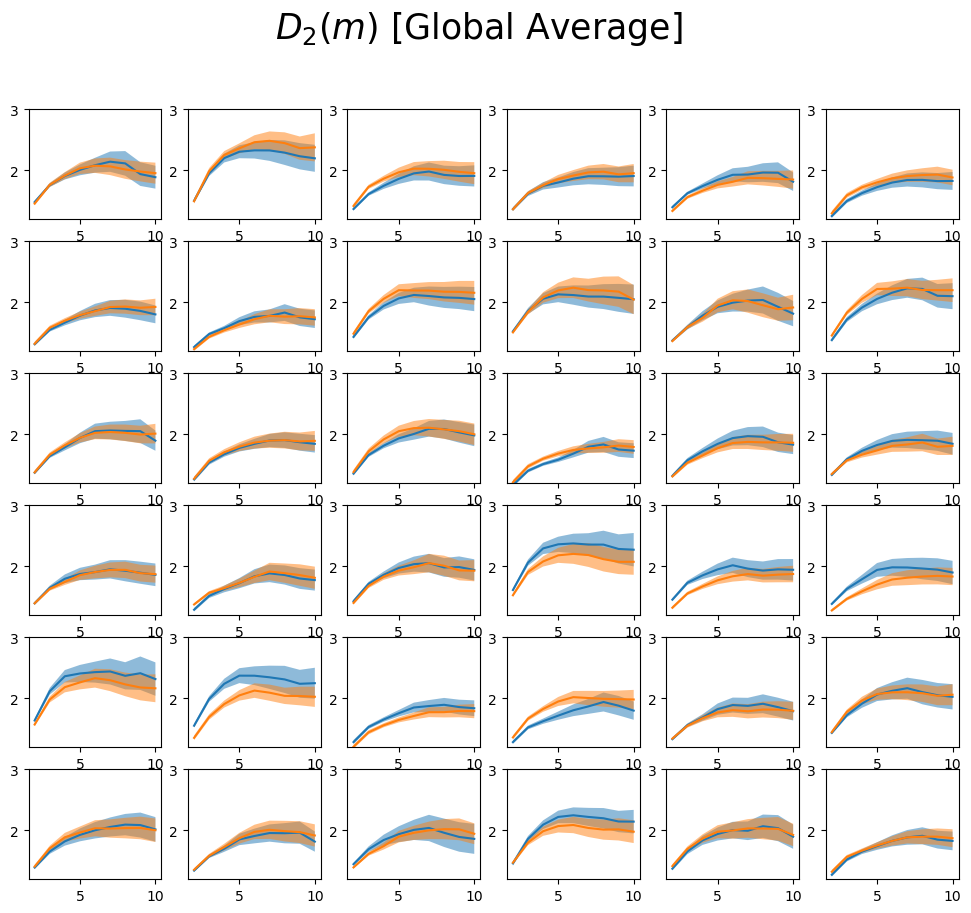

In [47]:
# Check expected attractor dimension 

sv_lb = lb

if clst == True:
    cl_idx = 1
    M = m[:,:,cl_idx,:]
    EM = em[:,:,cl_idx,:]

    sv_lb = lb + str(cl_idx)

    title = '$D_{2}(m)$ [' + clust_dict[lb][cl_idx] + ']'

else:
    M = m.mean(axis = 2)
    EM = em.mean(axis = 2)

    sv_lb = lb

    title = '$D_{2}(m)$ [' + clust_dict[lb] + ']'

fig, axs = plt.subplots(6,6, figsize = (12,10))

for j, ax in enumerate(axs.flat):
    
    ax.plot(embs, M[j,0,:], label = 'Conscious')
    ax.fill_between(embs, M[j,0,:]-EM[j,0,:], M[j,0,:]+EM[j,0,:], alpha = 0.5)

    ax.plot(embs, M[j,1,:], label = 'Unconscious')
    ax.fill_between(embs, M[j,1,:]-EM[j,1,:], M[j,1,:]+EM[j,1,:], alpha = 0.5)

    ax.set_ylim(1.2,3)
    #ax.set_title(sub_list[j])

fig.suptitle(title, size = 25)

plt.savefig(wf_path + 'pics/backward_masking/'+ sv_lb + avg +'Dattractor.png', dpi = 300)

fig.show()

*Following cells do not take advantage of MNE data structure*

***Integration will follow***

**Print 2-dim Time Embedding trajectories**

In [ ]:
###Set parameters

#Time delay
tau = 20

#Number of datapoints to ignore from start and end of signals
trim = 0

#Experiment conditions to pull from
conditions = ['S__','S_1']

#POIs (Put a function here at some point)
poi_idx = ch_clust_idx

#Initialize directory
os.makedirs('./pics/backward_masking/2dim_emb/', exist_ok = True)

###Multiprocessing

#Create iterable function
def Sub_2dimPics(subID):

    twodim_graphs(subID, tau = tau, trim = trim, conditions = conditions, channels_idx = poi_idx)

    return

#Set multiprocessing parameters
workers = 2
chk_size = int(len(sub_list)/workers) + 1

#Run calculations
if __name__ == '__main__':
    with Pool(workers) as p:
        p.map(Sub_2dimPics, sub_list, chk_size)


**Calculate and save optimal $\tau$ and $n$ for Time Embedding**

In [ ]:
###Set parameters

#Metrics calculated by SSub_ntau
metrics = ['t', 'n']

#Experiment conditions to pull from
conditions = ['S__', 'S_1']

#POIs
poi_idx = ch_clust_idx

#Initzialize dataframe for results
df = init_Frame(conditions, poi_idx, metrics)

###Multiprocess

#Create iterable function
def Sub_Results(subID):

    rs = SSub_ntau(subID, conditions = conditions, channels_idx = poi_idx)

    return rs

#Set multiprocessing parameters
workers = 2
chk_size = int(len(sub_list)/workers) + 1

#Run calculations
if __name__ == '__main__':
    with Pool(2) as p:
        rows = p.imap(Sub_Results, sub_list, chk_size)

        i = 0
        for row in rows:

            df.loc[i] = row

            i = i +1

###Save results
df.to_csv(bw_path + str(len(poi_idx)) + 'pois_TDEMBparams.csv', sep = ';', index = False)

**Plot time signal of POIs**

In [ ]:
#Plotting and gathering files in a smart way (Courtesy of Alessio)

conds = ['S__', 'S_1'] # S__ : conscious, S_1 : unconscious
fig,axs = plt.subplots(6,6, figsize=(12,10))
for i, ax in enumerate(axs.flat):
    print('sub '+str(i))
    sub = sub_list[i]
    folder = '/home/lunis/Documents/EEG/data/backward_masking/subj' + sub + '_band_resample/'
    all_files = os.listdir(folder)
    # cond = 'S_1' # unconscious

    # Loop over conditions (conscious and unconscious)
    for cond in conds:
        my_cond_files = [f for f in all_files if cond in f ]

        # Loop over trials of the present conditions
        all_trials = np.empty((0,451))
        for f in my_cond_files:
            path = folder+f
            # Load the .mat file (adjust the path)
            mat_data = sio.loadmat(path)

            # Inspect the keys in the .mat file
    #         print(mat_data['F'][ch_clust_idx].shape)
            data = mat_data['F'][ch_clust_idx]
    #         plt.plot(data.mean(axis=0))
        #     for e in data:
        #         plt.plot(e)
            all_trials = np.concatenate((all_trials, data.mean(axis=0)[np.newaxis, :]))
#         print(all_trials.shape)
        ax.plot(all_trials.mean(axis=0), label=cond)
        ax.axvspan(150, 250, color='grey', alpha=0.15)
#     ax.legend()
plt.savefig(path + 'plottini_all_sub_18_el.png', dpi=300)